# Voltage analysis

Three nights were observed with different VI+ settings:

<table>
<tr>
<th>Actions</th>
<th>Night</th>
<th>VI+</th>
</tr>
<tr>
<td>104357, 104358</td>
<td>20150609</td>
<td>122</td>
</tr>
<tr>
<td>104400, 104401</td>
<td>20150610</td>
<td>223</td>
</tr>
<tr>
<td>104439, 104440</td>
<td>20160611</td>
<td>168</td>
</tr>
</table>

The data are located in the `data` subdirectory, labeled as the voltages. They are the full photometry output files which should contain all metadata required. We look at the NG2000 field to start with as other cameras have observed this field.

We first compare FRMS diagrams, plotting the fractional for each voltage setting - the input catalogue used is the same so the stars are the same - and hope that night-to-night effects are minimal.

<div id="toc"></div>

Todo:

* Compare with other cameras
    * sky background behaviour should be the same camera to camera so can look for differences which indicate camera behaviour
    * eyeball individual objects
        * objects which start to behave well with 223
        * objects which remain "saturated" in 223

### **[Skip to analysis](#Analysis)**

## Fractional rms comparison

In [1]:
%matplotlib inline
%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from itertools import combinations
from collections import namedtuple
from contextlib import contextmanager
from itertools import *
import seaborn as sns

sns.set(context='poster', style='white')

Ensure the data files are linked. The `Makefile` in the current directory performs this step.

In [2]:
%%file Makefile
TOCJS := $(shell ipython locate)/nbextensions/toc.js
TOCCSS := $(shell ipython locate)/nbextensions/toc.css
    
all: data custom

data: data/122.fits data/168.fits data/223.fits
    
custom: $(TOCJS) $(TOCCSS)

data/122.fits: /ngts/pipedev/ParanalOutput/running-the-pipeline/20150609-ng2000-802/AperturePhot/output/20150609-ng2000-802/20150609-ng2000-802_image_NG2000-4500/output.fits
	cd data && ln -sv $< $(notdir $@)

data/168.fits: /ngts/pipedev/ParanalOutput/running-the-pipeline/20150611-ng2000-802/AperturePhot/output/20150611-ng2000-802/20150611-ng2000-802_image_NG2000-4500/output.fits
	cd data && ln -sv $< $(notdir $@)

data/223.fits: /ngts/pipedev/ParanalOutput/running-the-pipeline/20150610-ng2000-802/AperturePhot/output/20150610-ng2000-802/20150610-ng2000-802_image_NG2000-4500/output.fits
	cd data && ln -sv $< $(notdir $@)

$(TOCJS):
	curl -L https://rawgithub.com/minrk/ipython_extensions/master/nbextensions/toc.js > $@
    
$(TOCCSS):
	curl -L https://rawgithub.com/minrk/ipython_extensions/master/nbextensions/toc.css > $@

Overwriting Makefile


In [3]:
!make

make: Nothing to be done for `all'.


Some helper functions and classes

In [4]:
@contextmanager
def subplots(*args, **kwargs):
    grid = kwargs.pop('grid', True)
    grid_which = kwargs.pop('grid_which', 'major')
    
    fig, axes = plt.subplots(*args, **kwargs)
    try:
        axes = axes.flatten()
    except AttributeError:
        pass
        
    yield (fig, axes)
    
    try:
        for ax in axes:
            ax.grid(grid, which=grid_which)
    except TypeError:
        axes.grid(grid, which=grid_which)
    
    fig.tight_layout()

In [5]:
def rms(d, *args, **kwargs):
    return np.sqrt(np.average(d ** 2, *args, **kwargs))

In [6]:
class Lightcurve(namedtuple('Lightcurve', ['mjd', 'flux'])):
    pass

In [7]:
class FRMS(object):
    '''
    Class to encapsulate the FRMS computation. Cache the statistics as they usually are
    called more than once.
    '''

    def __init__(self, flux, detmag, mjd, sky, bias, voltage):
        self.flux = flux
        self.detmag = detmag
        self.mjd = mjd
        self.sky = sky
        self.bias = bias
        self.voltage = voltage
        self._med_flux = None
        self._med_detmag = None
        self._frms = None
        self._frms_detmag = None

        self.med_sky = np.median(self.sky)
        self.rms_sky = rms(self.sky)
        self.med_bias = np.median(self.bias)
        self.rms_bias = rms(self.bias)

    def shape(self):
        return self.flux.shape

    def __str__(self):
        return 'FRMS VI+{voltage}'.format(voltage=self.voltage)
    
    def _choose_lightcurves_from_ind(self, ind):
        for lc in self.flux[ind]:
            yield Lightcurve(self.mjd, lc)

    def _choose_lightcurves_ind(self, flux_lims, frms_lims, random=False):
        flux_ind = (self.med_flux >= min(flux_lims)) & (self.med_flux <= max(flux_lims))
        frms_ind = (self.frms >= min(frms_lims)) & (self.frms <= max(frms_lims))
        combined_ind = flux_ind & frms_ind
        assert combined_ind.any(), 'Cannot find any apertures within the limits specified'
        ind = np.where(combined_ind)[0]
        
        if random:
            np.random.shuffle(ind)
        
        return ind

    
    def choose_lightcurves(self, flux_lims, frms_lims, random=False):
        ind = self._choose_lightcurves_ind(flux_lims, frms_lims, random=random)
        return self._choose_lightcurves_from_ind(ind)

    @classmethod
    def from_file(cls, filename, voltage):
        with fits.open(filename) as infile:
            imagelist = infile['imagelist'].data
            flux = infile['flux'].data
            detmag = infile['casudet'].data - 25.

        return cls(flux, detmag, imagelist['tmid'], imagelist['skylevel'], imagelist['biasover'],
                   voltage)

    @property
    def med_flux(self):
        '''
        The median flux per lightcurve
        '''
        if self._med_flux is None:
            self._med_flux = np.median(self.flux, axis=1)
        return self._med_flux
    
    @property
    def med_detmag(self):
        '''
        The median detrended mags per lightcurve
        '''
        if self._med_detmag is None:
            self._med_detmag = np.median(self.detmag, axis=1)
        return self._med_detmag


    @property
    def frms(self):
        '''
        Fractional rms: std / median(flux)
        '''
        if self._frms is None:
            std = np.std(self.flux, axis=1)
            self._frms = std / self.med_flux
        return self._frms

    
    @property
    def frms_detmag(self):
        '''
        Fractional rms: std / median(flux)
        '''
        if self._frms_detmag is None:
            self._frms_detmag = np.std(self.detmag, axis=1)
        return self._frms_detmag
    

    @property
    def extra_counts(self):
        return np.median(self.sky + self.bias)

    def extra_counts_over(self, other):
        return self.extra_counts - other.extra_counts

In [8]:
class Table(object):
    '''
    Helper class for printing nice tables
    '''

    def __init__(self, headings, data):
        self.headings = headings
        self.data = data

    def _repr_html_(self):
        out = []
        out.append('<table><tr>')
        for entry in self.headings:
            out.append('<th>{}</th>'.format(str(entry)))
        for row in self.data:
            out.append('<tr>')
            for entry in self.headings:
                out.append('<td>{}</td>'.format(row[entry]))
            out.append('</tr>')
        out.append('</tr></table>')
        return ''.join(out)

Load all data into classes, and store the voltage results in a list for access later.

In [9]:
frms_122 = FRMS.from_file('data/122.fits', 122)
frms_223 = FRMS.from_file('data/223.fits', 223)
frms_168 = FRMS.from_file('data/168.fits', 168)
assert frms_122.shape()[0] == frms_223.shape()[0] == frms_168.shape()[0]

In [10]:
datasets = [frms_122, frms_168, frms_223]

Choose the flux values from voltage VI+168 as a reference flux, and plot all values against this, so we are only comparing the noise values.

In [11]:
ref_flux = frms_168.med_flux

To get nicer interleaved plotting, pre-compute some z-order values.

In [12]:
zorder_options = np.arange(len(datasets)) + 10
zorder_array = []
for _ in range(datasets[0].frms.size):
    zorder_values = np.random.choice(zorder_options, size=len(datasets), replace=False)
    zorder_array.append(zorder_values)
zorder_array = np.array(zorder_array).T

Store the colours. Reverse the array to get the colours as RGB.

In [13]:
colours = sns.color_palette(n_colors=len(datasets))[::-1]

#### Analysis

Now plot the frms values for each voltage against the reference flux

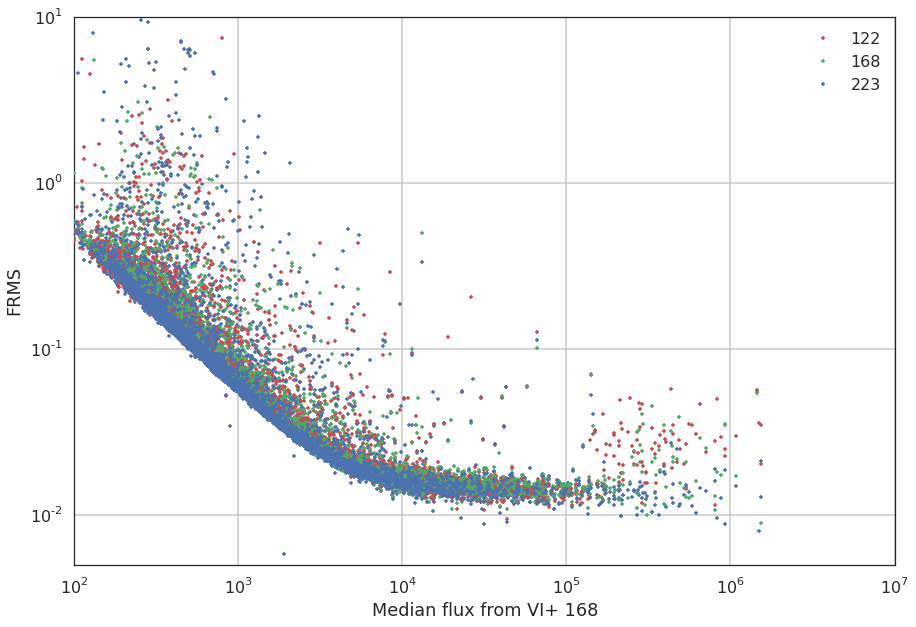

In [14]:
markersize = 7
xlabel = 'Median flux from VI+ 168'
with subplots() as (fig, axis):
    for dataset, zorder_values, colour in zip(datasets, zorder_array, colours):
        for i, z in enumerate(zorder_options):
            ind = zorder_values == z
            if i == 0:
                axis.loglog(ref_flux[ind], dataset.frms[ind], '.', label=dataset.voltage, zorder=z, color=colour,
                           ms=markersize)
            else:
                axis.loglog(ref_flux[ind], dataset.frms[ind], '.',                        zorder=z, color=colour,
                           ms=markersize)

    axis.legend(loc='best')
    axis.set(xlabel=xlabel, ylabel='FRMS', xlim=(1E2, 1E7), ylim=(5E-3, 1E1))

This is very confusing to look at. It is possible the VI+223 saturated stars are more well behaved. We note that saturation occurs at roughly slightly over 1E5 counts.

### Saturation level

Let's look at the point of saturation for the three voltages in more detail.

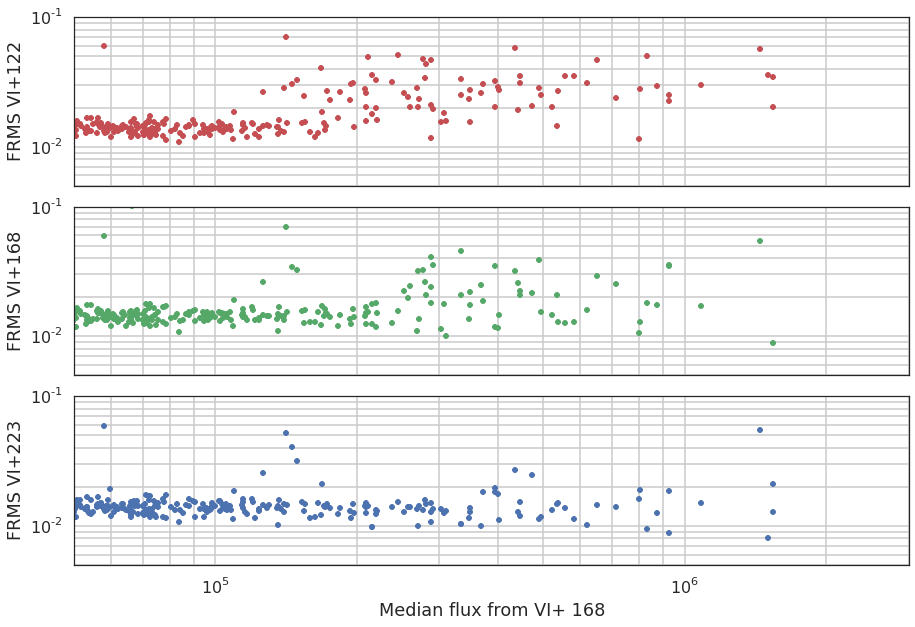

In [15]:
with subplots(len(datasets), 1, sharex=True, sharey=True, grid_which='both') as (fig, axes):
    for (dataset, axis, colour) in zip(datasets, axes, colours):
        axis.loglog(ref_flux, dataset.frms, '.', color=colour)
        axis.set(xlim=(5E4, 3E6), ylim=(5E-3, 1E-1), ylabel=dataset)
    axes[-1].set(xlabel=xlabel)

Clearly increasing the VI+ setting improves the saturated star behaviour, for almost the entire range! The saturation point essentially matches with VI+ setting. We now plot the same data but split horizontally instead of vertically to look at the noise levels for the bright unsaturated stars.

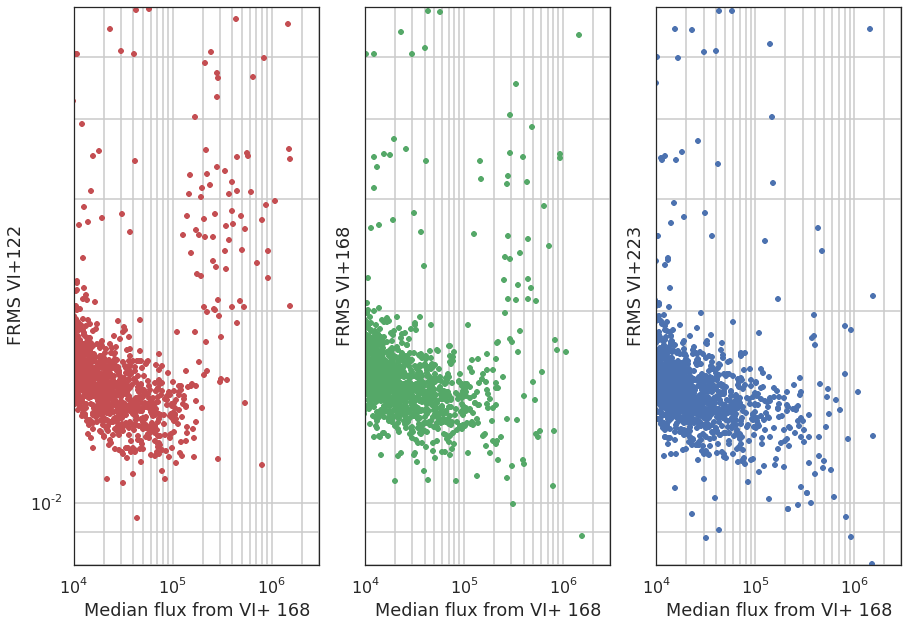

In [16]:
with subplots(1, len(datasets), sharex=True, sharey=True, grid_which='both') as (fig, axes):
    for (dataset, axis, colour) in zip(datasets, axes, colours):
        axis.loglog(ref_flux, dataset.frms, '.', color=colour)
        axis.set(xlim=(1E4, 3E6), ylim=(8E-3, 6E-2), xlabel=xlabel, ylabel=dataset)

I would say the noise behaviour from VI+122 is lower. Perhaps we have a compromise between noise level and saturation level. We select stars where the flux in 168 is between $4\times 10^4$ and $1 \times 10^5$ counts and print the median values.

In [17]:
bright_end = (ref_flux >= 4E4) & (ref_flux <= 1E5)
Table(headings=['Voltage', 'Median frms'], data=[
        {'Voltage': dataset.voltage,
         'Median frms': np.median(dataset.frms[bright_end]) * 1000.}
        for dataset in datasets])

Voltage,Median frms
122,14.1250797721592
168,14.577841245234545
223,14.045149827422005


This table suggests that the bulk noise level for 223 is *lowest*. Now this flux is dominated by extinction, so perhaps we need to look at detrended flux?

### Viewing the bias level and sky background level

Finally we must assess the bias level and sky background level for the three nights to ensure that this change in saturation is not due to this.

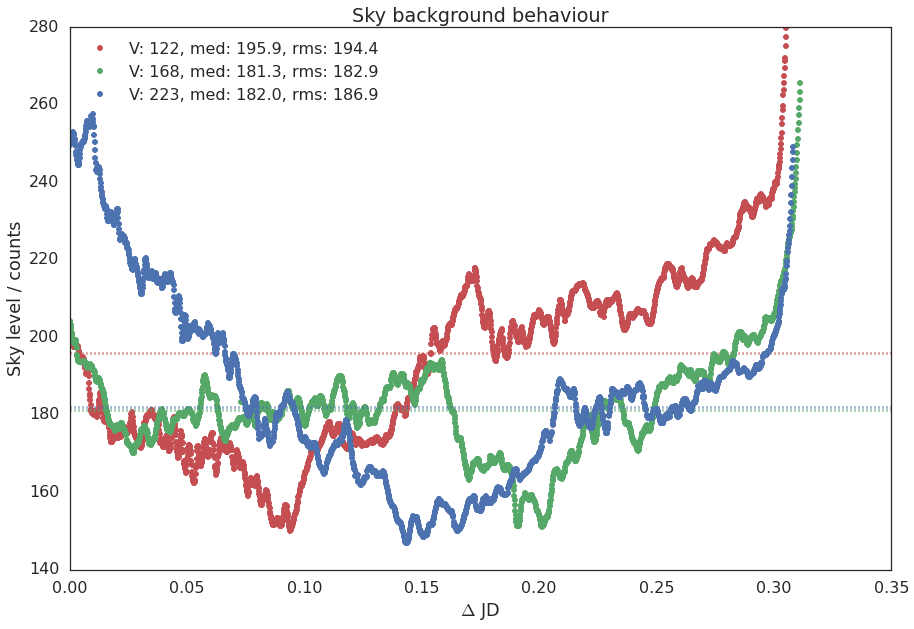

In [18]:
with subplots(grid=False) as (fig, axis):
    for (dataset, colour) in zip(datasets, colours):
        label = 'V: {voltage}, med: {median:.1f}, rms: {rms:.1f}'.format(
            voltage=dataset.voltage,
            median=dataset.med_sky,
            rms=dataset.rms_sky)
        axis.plot(dataset.mjd - dataset.mjd.min(), dataset.sky, '.', color=colour, label=label)
        axis.axhline(dataset.med_sky, color=colour, ls=':')
    axis.legend(loc='best')
    axis.set(xlabel=r'$\Delta$ JD', ylabel='Sky level / counts', title='Sky background behaviour')

The sky levels for 168 and 223 are similar. The sky level for 122 is a bit higher. Overall they are pretty similar, I don't think this will affect the saturation level too much.

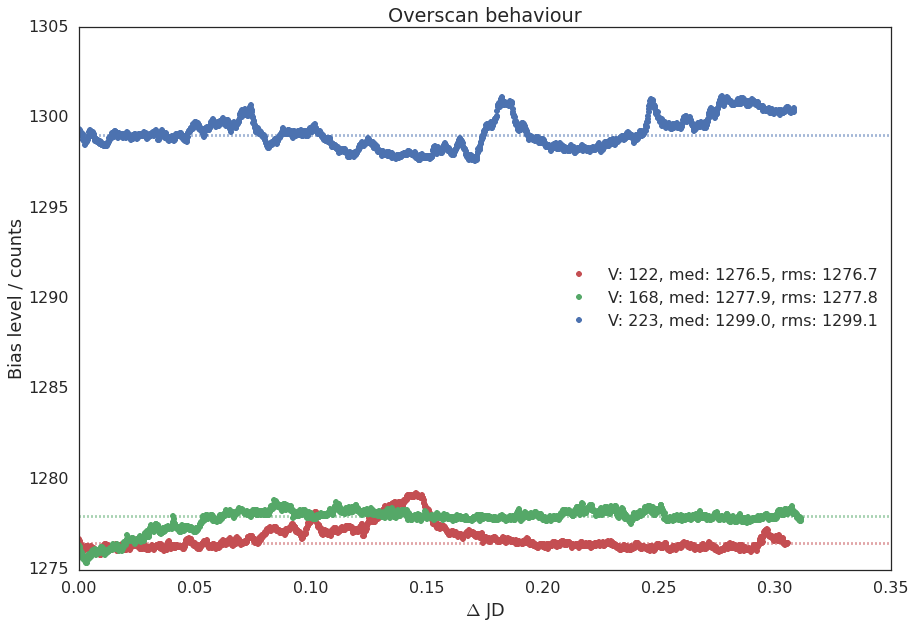

In [19]:
with subplots(grid=False) as (fig, axis):
    for (dataset, colour) in zip(datasets, colours):
        label = 'V: {voltage}, med: {median:.1f}, rms: {rms:.1f}'.format(
            voltage=dataset.voltage,
            median=dataset.med_bias,
            rms=dataset.rms_bias)
        axis.plot(dataset.mjd - dataset.mjd.min(), dataset.bias, '.', color=colour, label=label)
        axis.axhline(dataset.med_bias, color=colour, ls=':')
    axis.legend(loc='best')
    axis.set(xlabel=r'$\Delta$ JD', ylabel='Bias level / counts', title='Overscan behaviour')

This difference is larger, but certainly not large - only ~20 counts in total. We now compare the extra counts in each voltage setting:

In [20]:
data = [{ 'Voltage': dataset.voltage, 'Extra counts': dataset.extra_counts,
         'Extra over 168': dataset.extra_counts_over(frms_168) }
    for dataset in datasets ]
Table(headings=['Voltage', 'Extra counts', 'Extra over 168'], data=data)

Voltage,Extra counts,Extra over 168
122,1473.0963134765625,13.8101806640625
168,1459.2861328125,0.0
223,1481.40966796875,22.12353515625


If anything, VI+223 has *more* extra counts than the other two, yet shows better saturation behaviour.

## Direct frms comparison

Since the previous plots were so confusing, lets compare the FRMS values from two voltages and take the ratio.

In [21]:
frms_combinations = [(frms_122, frms_168), (frms_168, frms_223), (frms_122, frms_223)]

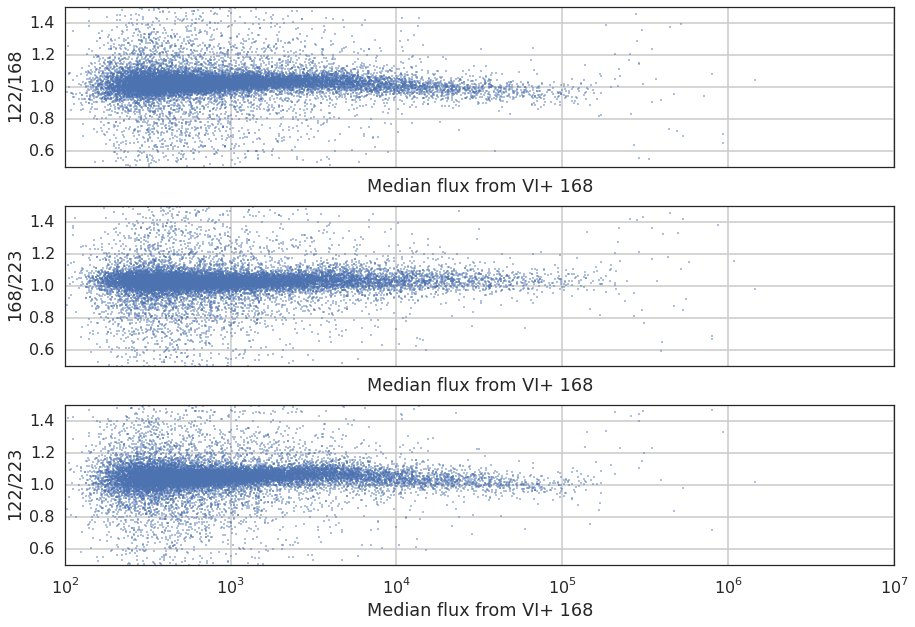

In [22]:
with subplots(len(datasets), 1, sharex=True, sharey=True) as (fig, axes):
    for (top, bottom), ax in zip(frms_combinations, axes):
        ratio = top.frms / bottom.frms
        ax.semilogx(ref_flux, ratio, '.', ms=3)
        ax.set(xlabel='Median flux from VI+ 168', ylabel='{}/{}'.format(top.voltage, bottom.voltage),
               xlim=(1E2, 1E7), ylim=(0.5, 1.5))

We see that the noise level for 223 appears the best.

## Flux level comparison

Now we look at the median flux values, essentially throughput. This one may not be so easy as night to night differences may play in but nonetheless...

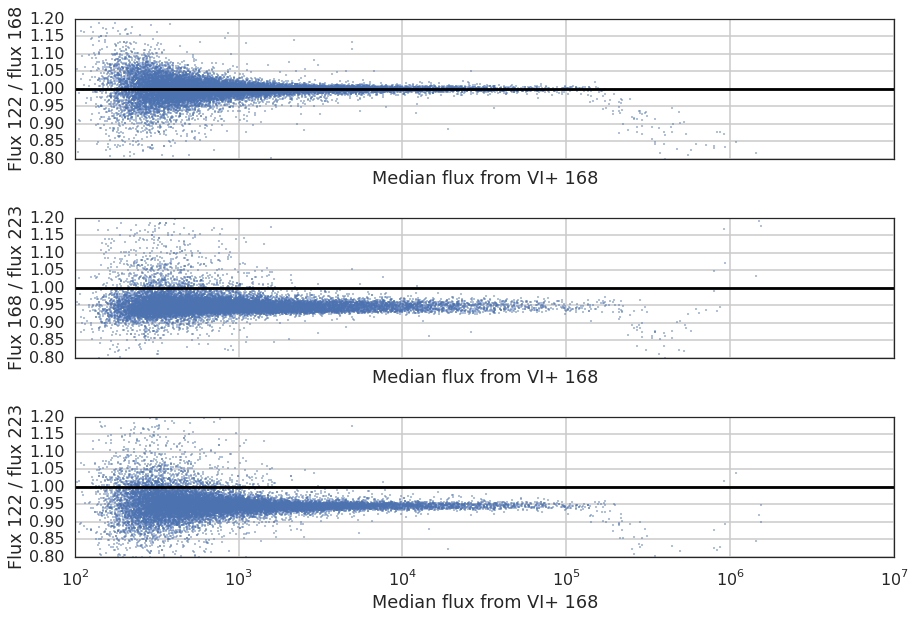

In [23]:
with subplots(len(datasets), 1, sharex=True, sharey=True) as (fig, axes):
    for (top, bottom), ax in zip(frms_combinations, axes):
        ax.semilogx(ref_flux, top.med_flux / bottom.med_flux, '.', ms=3)
        ax.axhline(1., color='k')

        ax.set(xlabel='Median flux from VI+ 168', ylabel='Flux {} / flux {}'.format(top.voltage, bottom.voltage),
              xlim=(1E2, 1E7), ylim=(0.8, 1.2))

## Faint stars

Judging by the [direct frms comparison](#Direct-frms-comparison) the best setting for faint stars is 223 again.

## Detrended flux analysis

We now study the bright stars and saturated stars using the FRMS as computed from the post-CASU-detrended magnitudes.

In [24]:
ref_detmag = frms_168.med_detmag
xmaglabel = r'$m_I$ VI+168'

First plot the full frms plots

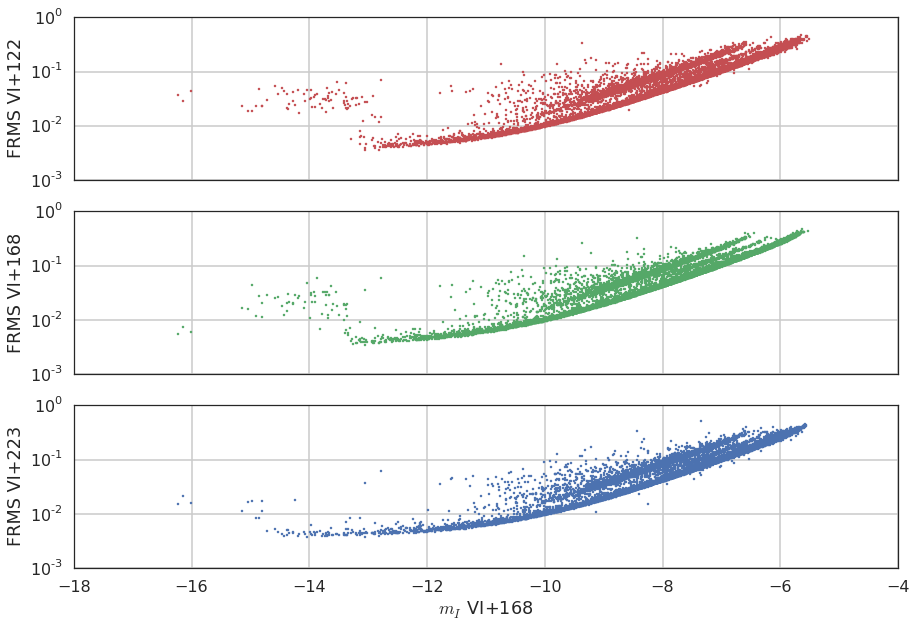

In [25]:
with subplots(len(datasets), 1, sharex=True, sharey=True) as (fig, axes):
    for (dataset, axis, colour) in zip(datasets, axes, colours):
        axis.semilogy(ref_detmag, dataset.frms_detmag, '.', color=colour, ms=5)
        axis.set(ylabel=dataset)
    axes[-1].set(xlabel=xmaglabel)

We really see the advantage of incresing the voltage level. The saturation level decreases dramatically! Again we zoom in on the bright stars.

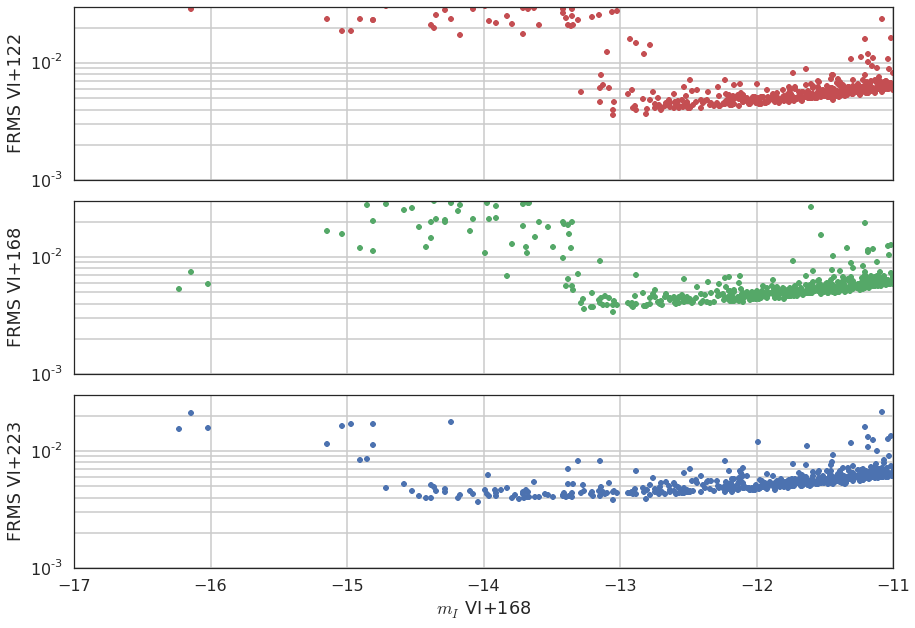

In [26]:
with subplots(len(datasets), 1, sharex=True, sharey=True, grid_which='both') as (fig, axes):
    for (dataset, axis, colour) in zip(datasets, axes, colours):
        axis.semilogy(ref_detmag, dataset.frms_detmag, '.', color=colour)
        axis.set(xlim=(-17, -11), ylim=(1E-3, 3E-2), ylabel=dataset)
    axes[-1].set(xlabel=xmaglabel)

We compare the bright star frms levels.

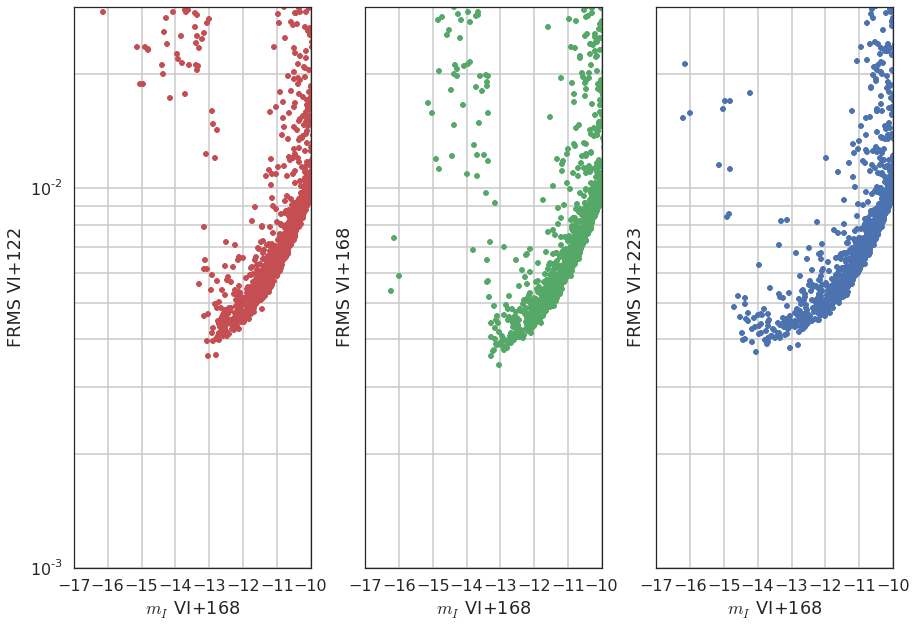

In [27]:
with subplots(1, len(datasets), sharex=True, sharey=True, grid_which='both') as (fig, axes):
    for (dataset, axis, colour) in zip(datasets, axes, colours):
        axis.semilogy(ref_detmag, dataset.frms_detmag, '.', color=colour)
        axis.set(xlim=(-17, -10), ylim=(1E-3, 3E-2), xlabel=xmaglabel, ylabel=dataset)

In [28]:
brightmag_ind = (ref_detmag < -11.5) & (ref_detmag > -12.5)
Table(headings=['Voltage', 'Median frms'], data=[
        {'Voltage': dataset.voltage,
         'Median frms': np.median(dataset.frms_detmag[brightmag_ind]) * 1000.}
        for dataset in datasets])

Voltage,Median frms
122,5.062027834355831
168,4.949487745761871
223,5.317804869264364


# Conclusions

It seems that the ideal setting is VI+223 based on the raw flux and detrended flux.

# Individual lightcurves

Let's look at a few cases:

* objects which are well behaved in two voltages (including VI+223)
    * to see how similar the nights are in general
* objects where they are saturated in VI+168 and not in VI+223
* objects which remain saturated in VI+223

### Well behaved lightcurves

In [29]:
n_lightcurves = 5

In [49]:
def plot_chosen_lightcurves(flux_lims, frms_lims, random=True):
    
    '''
    Pick objects from the flux limits given and the flux in `frms_122`.
    
    Plot one object per panel in the three different voltages/nights.
    
    Normalise each object by its median flux to remove constant offsets between the nights/voltages.
    '''

    ind = frms_122._choose_lightcurves_ind(flux_lims=flux_lims, frms_lims=frms_lims, random=True)
    print('Chosen {} lightcurves'.format(ind.size))
    
    with subplots(n_lightcurves, 1, sharex=True) as (fig, axes):
        for dataset, colour in zip(datasets, colours):
            for (lc, axis) in zip(dataset._choose_lightcurves_from_ind(ind), axes):
                mjd0 = int(lc.mjd.min())
                axis.plot(lc.mjd - mjd0, lc.flux / np.median(lc.flux), '.', ms=5, color=colour)
                
    return ind

Chosen 1007 lightcurves


array([ 1600,  4991,  2673, ..., 10308,   120,  1436])

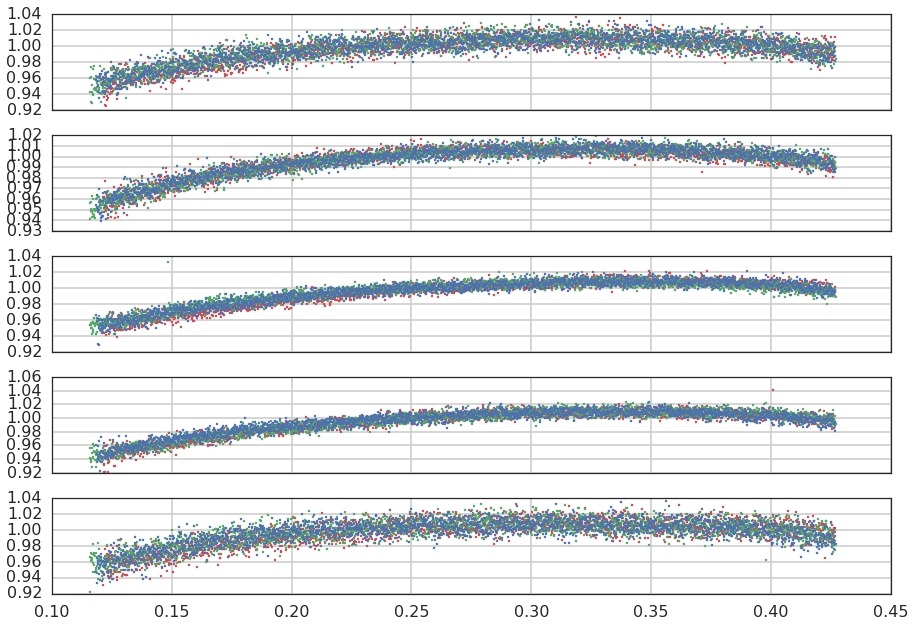

In [48]:
plot_chosen_lightcurves(flux_lims=(1E4, 1E5), frms_lims=(1E-2, 3E-2), random=True)

These lightcurves look encouragingly similar. Let's have a look at some objects which are saturated in 122 and ok in 223.

Chosen 8 lightcurves


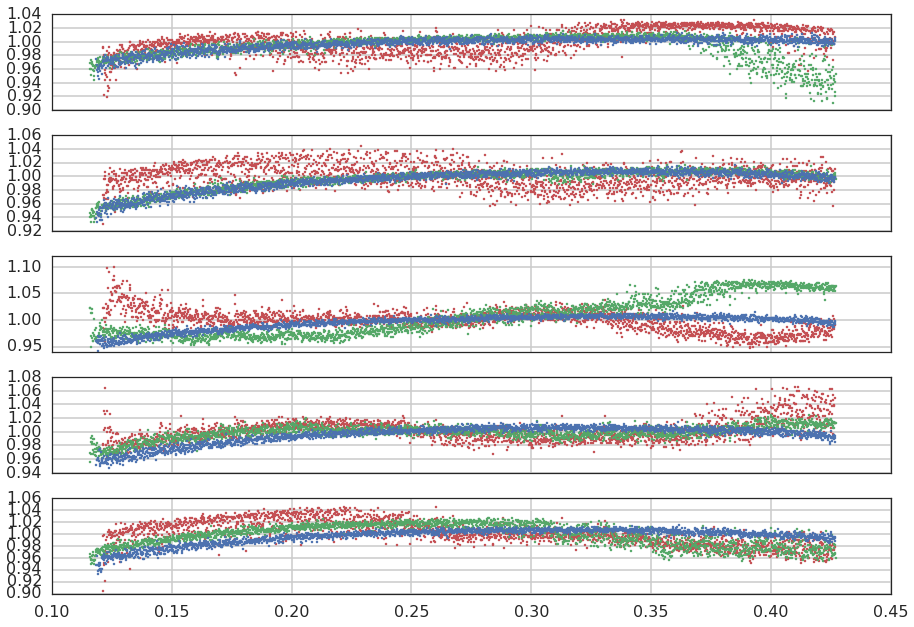

In [50]:
ind = plot_chosen_lightcurves(flux_lims=(2E5, 3E5), frms_lims=(1E-3, 2E-2), random=True)

As expected the red (and to some extent green) lightcurves show different behaviour to the blue lightcurves indicating different saturation behaviour. We look at the 223 lightcurves in more detail.

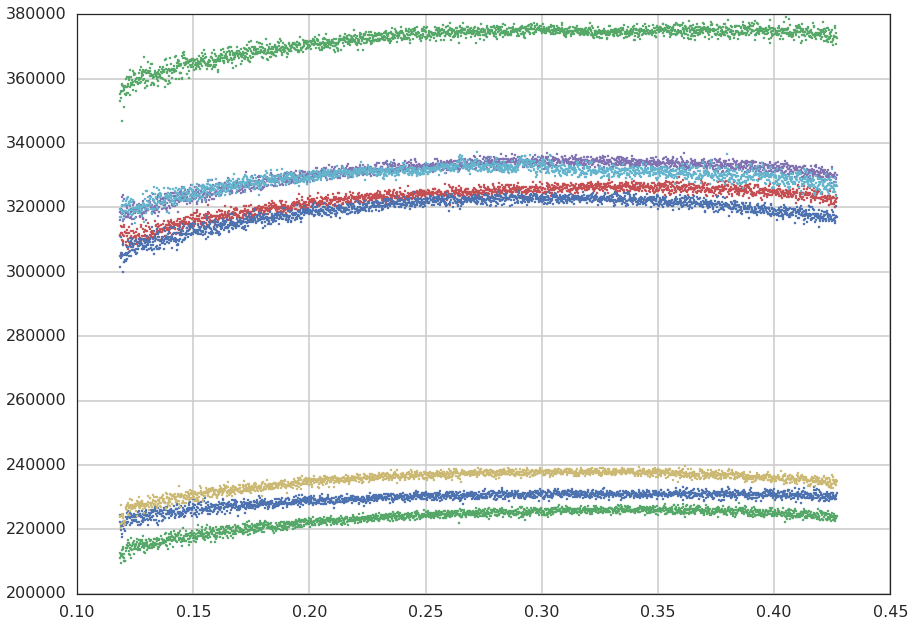

In [54]:
with subplots() as (fig, axis):
    for lc in frms_223._choose_lightcurves_from_ind(ind):
        mjd0 = int(lc.mjd.min())
        axis.plot(lc.mjd - mjd0, lc.flux, '.', ms=5)

When looking at these lightcurves in more detail, above a certain brightness they do seem to show "saturation" behaviour.

What about lightcurves still saturated in VI+223?

Chosen 4 lightcurves


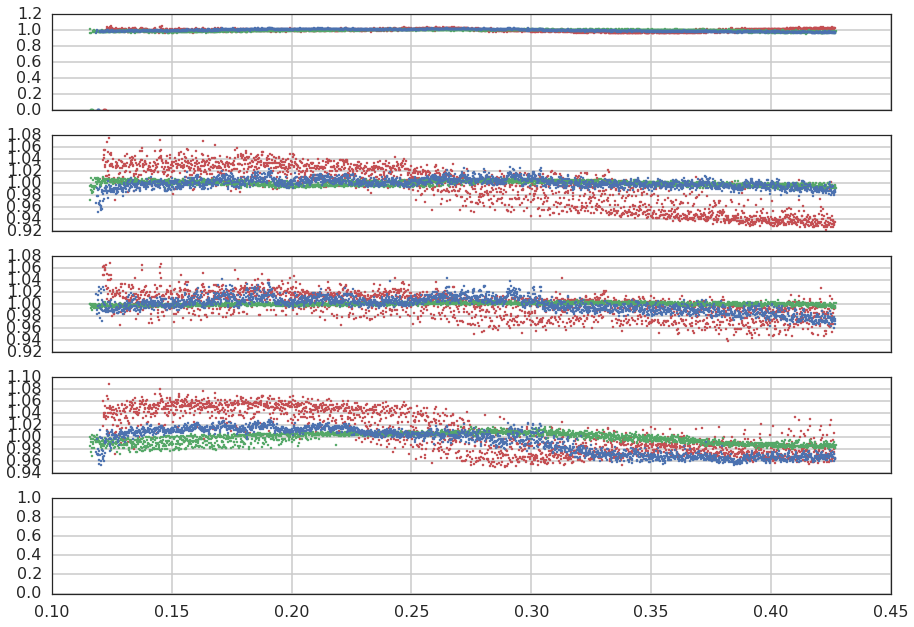

In [55]:
ind = plot_chosen_lightcurves(flux_lims=(1E6, 1E7), frms_lims=(1E-3, 1E-1), random=True)

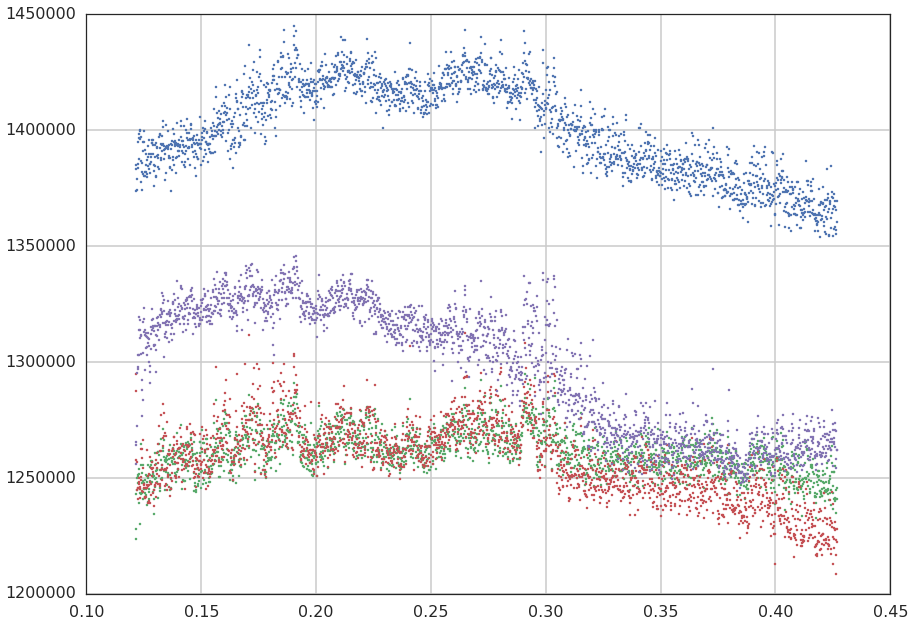

In [56]:
# Remove the first 20 points as they are outliers
npoints_to_skip = 20
with subplots() as (fig, axis):
    for lc in frms_223._choose_lightcurves_from_ind(ind):
        mjd0 = int(lc.mjd.min())
        axis.plot((lc.mjd - mjd0)[npoints_to_skip:], lc.flux[npoints_to_skip:], '.', ms=5)

These lightcurves look very similar to each other. This might be expected if the saturation behaviour of stars is quite similar. We can look at larger apertures for these objects to see if the behaviour improves

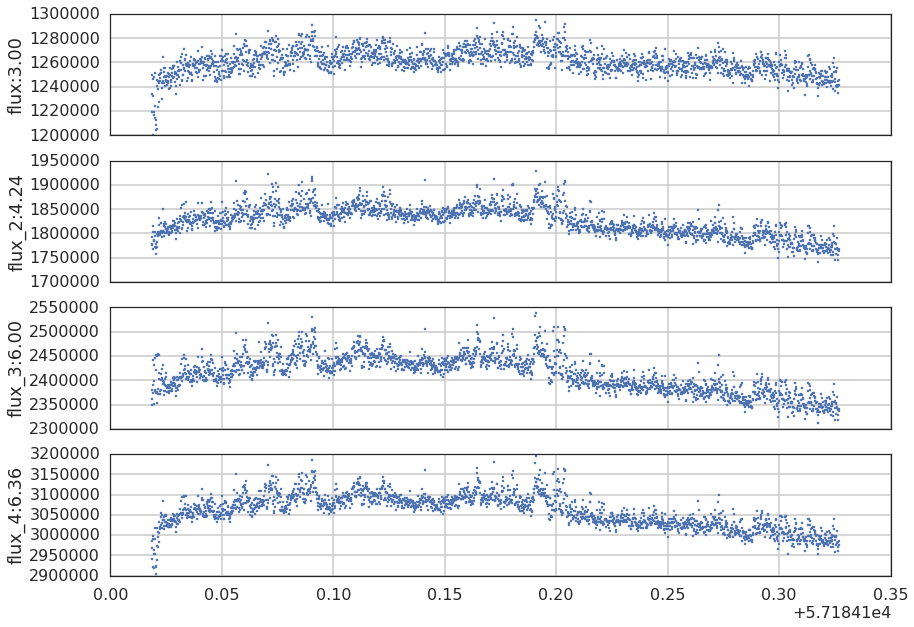

In [61]:
keys = ['flux', 'flux_2', 'flux_3', 'flux_4']
rcore = 3.
radii = [rcore, np.sqrt(2) * rcore, 2 * rcore, 3 * np.sqrt(2) * rcore / 2.]
with subplots(len(keys), 1, sharex=True) as (fig, axes):
    for key, axis, radius in zip(keys, axes, radii):
        with fits.open('data/223.fits') as infile:
            hdu = infile[key]
            lc = hdu.section[ind][1]

        axis.plot(frms_223.mjd, lc, '.', ms=5)
        axis.set(ylabel='{key}:{radius:.2f}'.format(key=key, radius=radius))

The lightcurves do not improve greatly with aperture size, suggesting that this is a lack of charge conservation rather than aperture losses.